# Kidney Exchange QAOA Example
Used samples from Classiq github on QAOA and internet for pyomo models  
Modified as needed for specfic problems 

<u>What is the Problem?</u>  
Currently there are more than 100,000 patients on the waitling list in the United States for a kidney transplant from a deceased donor. This is addressed by the a program called the Kidney Exchange Program.  
In a s donor pair there is a recipient who needs a kidney transplant and a donor who is willing to give their kidney to the recipient. About 1/3 of those pairs are not compatible for a direct exchange. This is tackled by considering two incompatible paiors together: donor 1 may be compatible with recpient 2 and donor 2 may be compantibel with recpient 1. In this example a two-way swap becomes feasible. This is the core of the program.  

This is consdered an NP-Hard combinatorial optimization problem that becomes exponetially mode difficult as the size of the pool increases. The longest chain in history involved 35 tranplants in the United States in 2015.

In [45]:
from pyomo.environ import *
from itertools import product

import matplotlib.pyplot as plt
import networkx as nx  # noqa
import numpy as np
import pandas as pd
import io
import sys
import time
from contextlib import redirect_stdout
from typing import List, Tuple, cast  # noqa

import pyomo.environ as pyo
from IPython.display import Markdown, display

## Create the pyomo model for simple kidney exhange problem 
<u>2 donors and 2 recipients since with 3 of each the classiq simualtor would error with more than 25 qubits requested</u>

The objective is to maxmize the compabtabilty scores between donors and patients  
In this problem the contrainst was that the individual compatibilty scores were less than <= 1

In [46]:
from pyomo.environ import *

# Sample data: patient-donor pairs and compatibility scores
patients=['P1','P2']
donors=['D1','D2']
N=len(patients)
M=len(donors)
#patients = ['P1', 'P2', 'P3']
#donors = ['D1', 'D2', 'D3']
compatibility = {
    ('P1', 'D1'): 0.8,
    ('P1', 'D2'): 0.5,
    #('P1', 'D3'): 0.3,
    ('P2', 'D1'): 0.7,
    ('P2', 'D2'): 0.9,
#    ('P2', 'D3'): 0.2,
#    ('P3', 'D1'): 0.4,
#    ('P3', 'D2'): 0.6,
#    ('P3', 'D3'): 0.1,
}

# Create Pyomo model
model = ConcreteModel()

# Define variables
model.x = Var(patients, donors, within=Binary)

# Define objective function
model.obj = Objective(expr=sum(model.x[p, d] for p in patients for d in donors),
                      sense=maximize)

# Define constraints
def compatibility_constraint(model, p, d):
    return model.x[p, d] * compatibility[p, d] <= 1

model.compatibility_constraint = Constraint(patients, donors, rule=compatibility_constraint)

# Solve the model
solver = SolverFactory('glpk')
solver.solve(model)

# Print the results
print("Optimal pairs:")
for p in patients:
    for d in donors:
        if model.x[p, d].value == 1:
            print(f"Patient {p} is matched with Donor {d} (Compatibility: {compatibility[p, d]})")


model.pprint()

Optimal pairs:
Patient P1 is matched with Donor D1 (Compatibility: 0.8)
Patient P1 is matched with Donor D2 (Compatibility: 0.5)
Patient P2 is matched with Donor D1 (Compatibility: 0.7)
Patient P2 is matched with Donor D2 (Compatibility: 0.9)
6 Set Declarations
    compatibility_constraint_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain                                                            : Size : Members
        None :     2 : compatibility_constraint_index_0*compatibility_constraint_index_1 :    4 : {('P1', 'D1'), ('P1', 'D2'), ('P2', 'D1'), ('P2', 'D2')}
    compatibility_constraint_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'P1', 'P2'}
    compatibility_constraint_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'D1', 'D2'}
    x_index : Size=1, Index=None, Ordered=True
        

## Start Generatng the QAOA Process
  
Create the inital parameters for the quantum circuit

In [47]:
from classiq import (
    Preferences,
    construct_combinatorial_optimization_model,
    set_preferences,
)
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=5, penalty_energy=3.0)

Classical optimizer part of the QAOA. The maximum number of iterations is set to 100.

In [48]:
optimizer_config = OptimizerConfig(
    max_iteration=100,
    alpha_cvar=1,
)

Combine everthing together to for the combinational optimization model.  
(1) PYOMO Model  
(2) QAOA inital circuit  
(3) Clasical optimizer

In [49]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

# defining cosntraint such as computer and parameters for a quicker and more optimized circuit.
preferences = Preferences(transpilation_option="none", timeout_seconds=3000)

qmod = set_preferences(qmod, preferences)

(1) Wite out the QMOD and preferences to a JSON file  
(2) Synthesize the model in Classiq interface  
(3) Show the Circuit  

In [50]:
from classiq import write_qmod
write_qmod(qmod, "Kidney Exchange")

In [51]:
from classiq import show, synthesize
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/acceed22-94f8-4d28-91fd-7352e288f061?version=0.41.2


Iteratively execuet the circuit and and check the convergence.


In [52]:
from classiq import execute
res = execute(qprog).result()

<i>Important to remember that this is a maximization problem when looking at the graph</i>

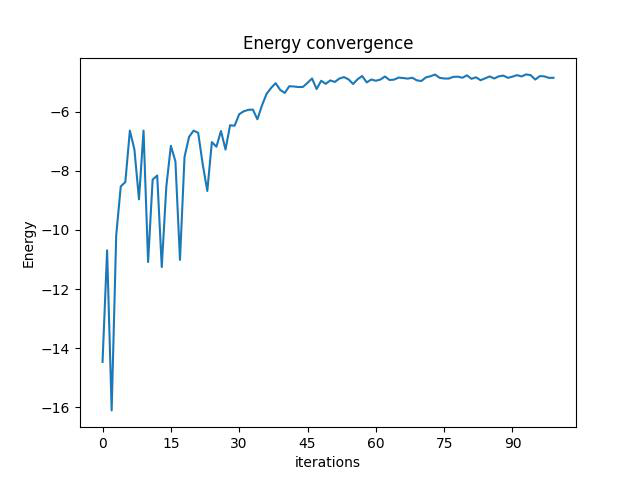

In [53]:
from classiq.execution import VQESolverResult

vqe_result=res[0].value
vqe_result.convergence_graph

## Retrieve the Best Solutions
- Print them out
- Graph them in hisotgram
- Show Donor - Recipients in Network Graph

In [54]:
import pandas as pd
from classiq.applications.combinatorial_optimization import (get_optimization_solution_from_pyo, )

solution = get_optimization_solution_from_pyo(model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy)

optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=True).head(10)

,probability,cost,solution,count
610,0.000488,-22.108891,"[1, 0, 0, 1]",1
744,0.000488,-20.132700,"[0, 0, 1, 0]",1
471,0.000488,-20.037462,"[0, 0, 0, 0]",1
999,0.000488,-18.966034,"[1, 0, 1, 1]",1
1048,0.000488,-18.299367,"[1, 0, 1, 0]",1
1090,0.000488,-17.966034,"[1, 1, 1, 1]",1
481,0.000488,-17.966034,"[1, 1, 1, 1]",1
798,0.000488,-17.870796,"[1, 1, 0, 1]",1
1016,0.000488,-17.870796,"[1, 0, 1, 1]",1
416,0.000977,-17.870796,"[1, 0, 1, 1]",2


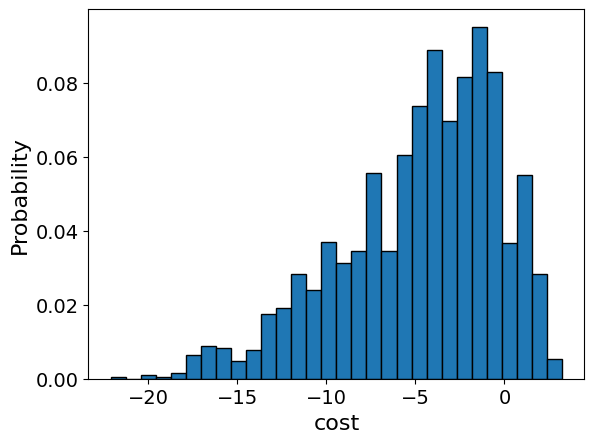

In [55]:
import matplotlib.pyplot as plt
optimization_result["cost"].plot(
    kind="hist", bins=30, edgecolor="black", weights=optimization_result["probability"]
)
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

**QAOA SOLUTION**
total cost=  -22.108890778533635


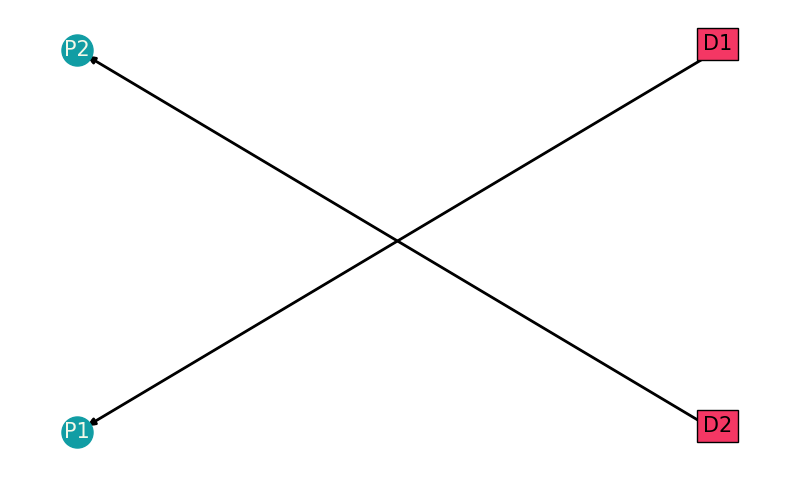

In [56]:
# This function plots the solution in a table and a graph


def plotting_sol(x_sol, cost, is_classic: bool):
    x_sol_to_mat = np.reshape(np.array(x_sol), [N, M])  # vector to matrix
    # opened facilities will be marked in red
    opened_fac_dict = {}
    for fa in range(N):
        if sum(x_sol_to_mat[fa, m] for m in range(M)) > 0:
            opened_fac_dict.update({donors[fa]: "background-color: #F43764"})

    # classical or quantum
    if is_classic == True:
        print("**CLASSICAL SOLUTION**")
        print("total cost= ", cost)
    else:
        print("**QAOA SOLUTION**")
        print("total cost= ", cost)

    # plotting in a table
    df = pd.DataFrame(x_sol_to_mat)
    df.columns = patients
    df.index = donors
    plotable = df.style.apply(lambda x: x.index.map(opened_fac_dict))
    print(plotable)

    # plotting in a graph
    graph_sol = nx.DiGraph()
    graph_sol.add_nodes_from(donors+patients)
    for n, m in product(range(N), range(M)):
        if x_sol_to_mat[n, m] > 0:
            graph_sol.add_edges_from(
                [(donors[m], patients[n])]#, weight=cost_matrix[n, m]
            )

    plt.figure(figsize=(10, 6))
    left = nx.bipartite.sets(graph_sol, top_nodes=patients)[0]
    pos = nx.bipartite_layout(graph_sol, left)

    nx.draw_networkx(
        graph_sol, pos=pos, nodelist=patients, font_size=22, font_color="None"
    )
    nx.draw_networkx_nodes(
        graph_sol, pos, nodelist=patients, node_color="#119DA4", node_size=500
    )
    for fa in donors:
        x, y = pos[fa]
        if fa in opened_fac_dict.keys():
            plt.text(
                x,
                y,
                s=fa,
                bbox=dict(facecolor="#F43764", alpha=1),
                horizontalalignment="center",
                fontsize=15,
            )
        else:
            plt.text(
                x,
                y,
                s=fa,
                bbox=dict(facecolor="#F4F9E9", alpha=1),
                horizontalalignment="center",
                fontsize=15,
            )

    nx.draw_networkx_edges(graph_sol, pos, width=2)
    labels = nx.get_edge_attributes(graph_sol, "weight")
    nx.draw_networkx_edge_labels(graph_sol, pos, edge_labels=labels, font_size=12)
    nx.draw_networkx_labels(
        graph_sol,
        pos,
        labels={co: co for co in patients},
        font_size=15,
        font_color="#F4F9E9",
    )

    plt.axis("off")
    plt.show()


best_solution = optimization_result.loc[optimization_result.cost.idxmin()]

plotting_sol(best_solution.solution, best_solution.cost, is_classic=False)